In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
%matplotlib inline

idx = pd.IndexSlice

In [2]:
skins = pd.read_excel("datasets/all_skins.xlsx", header = [0,1], index_col = 0)

In [209]:
skins = skins.drop(labels = "2020-09-14", axis = 1) # 9/14/2020 data was not complete so dropped to preserve accuracy

C:\Users\William Huang\miniconda3\envs\datascience\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [210]:
# created a copy of skins as loading the file can take too long
# accidental changes to the dataframe can be reverted through this clean copy

skins_copy = skins.copy()

In [3]:
skins

Weapon              Collection            Quality  \
      Unnamed: 1_level_1      Unnamed: 2_level_1 Unnamed: 3_level_1   
0              CZ75-Auto  The Baggage Collection     Consumer Grade   
1              CZ75-Auto  The Baggage Collection     Consumer Grade   
2              CZ75-Auto  The Baggage Collection     Consumer Grade   
3              CZ75-Auto  The Baggage Collection     Consumer Grade   
4              CZ75-Auto  The Baggage Collection     Consumer Grade   
...                  ...                     ...                ...   
10276       Hydra Gloves             Clutch Case      Extraordinary   
10277       Hydra Gloves             Clutch Case      Extraordinary   
10278       Hydra Gloves             Clutch Case      Extraordinary   
10279       Hydra Gloves             Clutch Case      Extraordinary   
10280       Hydra Gloves             Clutch Case      Extraordinary   

                    Skin          Condition           StatTrak  \
      Unnamed: 4_level_1 Unnamed: 5_level_1 Unnamed: 6_level_1   
0            Green Plaid     Battle-Scarred              False   
1            Green Plaid          Well-Worn              False   
2            Green Plaid       Field-Tested              False   
3            Green Plaid       Minimal Wear              False   
4            Green Plaid        Factory New              False   
...                  ...                ...                ...   
10276           Mangrove     Battle-Scarred              False   
10277           Mangrove          Well-Worn              False   
10278           Mangrove       Field-Tested              False   
10279           Mangrove       Minimal Wear              False   
10280           Mangrove        Factory New              False   

                Souvenir 2013-08-01        2013-08-02  ...  2020-09-10         \
      Unnamed: 7_level_1      Price Volume      Price  ...       Price Volume   
0                    0.0        NaN    NaN        NaN  ...         NaN    NaN   
1                    0.0        NaN    NaN        NaN  ...    0.555000    2.0   
2                    0.0        NaN    NaN        NaN  ...    0.456000    1.0   
3                    0.0        NaN    NaN        NaN  ...    0.821000    1.0   
4                    0.0        NaN    NaN        NaN  ...    1.080000    3.0   
...                  ...        ...    ...        ...  ...         ...    ...   
10276                0.0        NaN    NaN        NaN  ...   96.189000    3.0   
10277                0.0        NaN    NaN        NaN  ...  105.708000    1.0   
10278                0.0        NaN    NaN        NaN  ...  100.482938    5.0   
10279                0.0        NaN    NaN        NaN  ...  124.767000    3.0   
10280                0.0        NaN    NaN        NaN  ...         NaN    NaN   

       2020-09-11         2020-09-12         2020-09-13        2020-09-14  \
            Price Volume       Price Volume       Price Volume      Price   
0        0.855000    4.0    1.089000    1.0    1.012000    2.0        NaN   
1             NaN    NaN    0.490000    1.0         NaN    NaN      0.570   
2        0.628047   10.0    0.400000    1.0    0.522000    5.0      0.515   
3        0.777000    2.0    0.812625    5.0    0.745000    2.0      0.841   
4        1.102500    2.0    1.147750    3.0    1.092000    2.0      1.050   
...           ...    ...         ...    ...         ...    ...        ...   
10276  103.997000    2.0   95.311000    3.0  101.277000    3.0    102.326   
10277  106.870000    1.0         NaN    NaN  104.022250    3.0     92.710   
10278   99.109773    9.0  104.087446   16.0  100.290398   11.0     95.190   
10279  131.277000    1.0  141.769000    3.0  120.625000    1.0    140.955   
10280         NaN    NaN         NaN    NaN         NaN    NaN        NaN   

              
      Volume  
0        NaN  
1        1.0  
2        2.0  
3        1.0  
4        1.0  
...      ...  
10276    1.0  
10277    1.0  
10278    1.0  
10279    1.0  

In [3]:
stickers = pd.read_excel("datasets/all_stickers.xlsx", header = [0,1], index_col = 0)

In [691]:
stickers

NameError: name 'stickers' is not defined

In [4]:
others = pd.read_excel("datasets/all_others.xlsx", header = [0,1], index_col = 0)

In [ ]:
others

In [16]:
# generating a basic dataframe to store calculated values
skins_data = skins.loc[:,["Weapon", "Collection", "Quality", "Skin", "Condition", "StatTrak", "Souvenir"]]

skins_data.columns = skins_data.columns.droplevel(1) #dropping the second level created for the multiindex

In [175]:
# dataframe of just skins and knives for easier data analysis
skins_price = skins.loc[:, idx[:, "Price"]]
skins_price.columns = skins_price.columns.droplevel(1)
skins_price.columns = pd.to_datetime(skins_price.columns)
skins_price

,2013-08-01,2013-08-02,2013-08-03,2013-08-04,2013-08-05,2013-08-06,2013-08-07,2013-08-08,2013-08-09,2013-08-10,...,2020-09-05,2020-09-06,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13,2020-09-14
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.627000,NaN,0.855000,1.089000,1.012000,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.555000,NaN,0.490000,NaN,0.570
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.453875,0.523000,0.497563,0.460000,0.478187,0.456000,0.628047,0.400000,0.522000,0.515
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.827000,0.834000,0.807000,0.874000,0.780000,0.821000,0.777000,0.812625,0.745000,0.841
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.315000,1.156750,1.167000,NaN,NaN,1.080000,1.102500,1.147750,1.092000,1.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,94.789750,104.314000,103.724000,98.191500,103.652375,96.189000,103.997000,95.311000,101.277000,102.326
10277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,93.859500,100.792000,97.992750,98.424500,95.089250,105.708000,106.870000,NaN,104.022250,92.710
10278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,103.006438,96.488969,100.806250,101.696438,103.107250,100.482938,99.109773,104.087446,100.290398,95.190
10279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,139.497000,119.080000,139.493500,133.385500,134.215875,124.767000,131.277000,141.769000,120.625000,140.955


In [210]:
# dataframe of skin prices with no knives included
skins_price = skins.loc[:, idx[:, "Price"]]
skins_price.insert(loc = 0, value = skins["Quality"], column = "Quality")
skins_price = skins_price[(skins_price["Quality"] != "Extraordinary") & (skins_price["Quality"] != "Covert")]
skins_price = skins_price.drop(columns = ["Quality"], axis = 1)
skins_price.columns = skins_price.columns.droplevel(1)
skins_price.columns = pd.to_datetime(skins_price.columns)
skins_price

C:\Users\William Huang\miniconda3\envs\datascience\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,2013-08-01,2013-08-02,2013-08-03,2013-08-04,2013-08-05,2013-08-06,2013-08-07,2013-08-08,2013-08-09,2013-08-10,...,2020-09-05,2020-09-06,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13,2020-09-14
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.627000,NaN,0.855000,1.089000,1.012,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.555,NaN,0.490000,NaN,0.570
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.453875,0.52300,0.497563,0.460,0.478187,0.456,0.628047,0.400000,0.522,0.515
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.827000,0.83400,0.807000,0.874,0.780000,0.821,0.777000,0.812625,0.745,0.841
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.315000,1.15675,1.167000,NaN,NaN,1.080,1.102500,1.147750,1.092,1.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,409.030000,434.467,NaN,NaN,NaN,NaN
7271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,488.08000,451.680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,613.505000,NaN,NaN,NaN,NaN,501.000000,NaN,548.980


In [203]:
# dataframe of skin prices with knives only included
skins_price = skins.loc[:, idx[:, "Price"]]
skins_price.insert(loc = 0, value = skins["Quality"], column = "Quality")
skins_price = skins_price[(skins_price["Quality"] == "Extraordinary") | (skins_price["Quality"] == "Covert")]
skins_price = skins_price.drop(columns = ["Quality"], axis = 1)
skins_price.columns = skins_price.columns.droplevel(1)
skins_price.columns = pd.to_datetime(skins_price.columns)
skins_price

C:\Users\William Huang\miniconda3\envs\datascience\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,2013-08-01,2013-08-02,2013-08-03,2013-08-04,2013-08-05,2013-08-06,2013-08-07,2013-08-08,2013-08-09,2013-08-10,...,2020-09-05,2020-09-06,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13,2020-09-14
191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.626250,4.416000,4.541000,4.682203,NaN,4.632750,4.495687,4.699750,4.780000,4.600
192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.257500,NaN,NaN,6.981000,NaN,NaN,6.810000,NaN,6.747500,NaN
193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.361812,4.626961,4.651113,4.359448,4.743819,4.399578,4.415102,4.514632,4.587083,4.660
194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.102344,6.215523,5.632000,5.680063,5.439479,5.614883,5.631332,5.508922,5.636793,5.920
195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.131812,9.016078,9.268500,9.514375,9.394250,9.380500,9.569000,9.057688,8.117500,8.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,94.789750,104.314000,103.724000,98.191500,103.652375,96.189000,103.997000,95.311000,101.277000,102.326
10277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,93.859500,100.792000,97.992750,98.424500,95.089250,105.708000,106.870000,NaN,104.022250,92.710
10278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,103.006438,96.488969,100.806250,101.696438,103.107250,100.482938,99.109773,104.087446,100.290398,95.190
10279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,139.497000,119.080000,139.493500,133.385500,134.215875,124.767000,131.277000,141.769000,120.625000,140.955


In [695]:
# dataframe of just volumes for easier data analysis
skins_vol = skins.loc[:, idx[:, "Volume"]]
skins_vol.columns = skins_vol.columns.droplevel(1)
skins_vol.columns = pd.to_datetime(skins_vol.columns)
skins_vol

,2013-08-01,2013-08-02,2013-08-03,2013-08-04,2013-08-05,2013-08-06,2013-08-07,2013-08-08,2013-08-09,2013-08-10,...,2020-09-04,2020-09-05,2020-09-06,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,4.0,1.0,2.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,2.0,7.0,1.0,6.0,1.0,10.0,1.0,5.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,5.0,2.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,2.0,3.0,2.0,NaN,NaN,3.0,2.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,5.0,2.0,1.0,2.0,4.0,3.0,2.0,3.0,3.0
10277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,2.0,2.0,4.0,2.0,3.0,1.0,1.0,NaN,3.0
10278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,8.0,7.0,3.0,10.0,6.0,5.0,9.0,16.0,11.0
10279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,2.0,1.0,2.0,2.0,4.0,3.0,1.0,3.0,1.0


# Basic Calculations

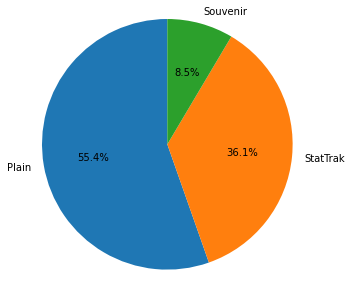

In [767]:
# getting count of stattrak, souvenir, and plain skins
st = len(skins[skins["StatTrak", "Unnamed: 6_level_1"] == True])
sv = len(skins[skins["Souvenir", "Unnamed: 7_level_1"] == True])
plain = len(skins) - st - sv

fig1, ax1 = plt.subplots()
fig1.set_size_inches(5,5)
ax1.pie([plain, st, sv], labels = ["Plain", "StatTrak", "Souvenir"], autopct = "%1.1F%%", startangle = 90)
ax1.axis("equal")
# plt.savefig("graphs/stsvpl.png", bbox_inches = "tight")

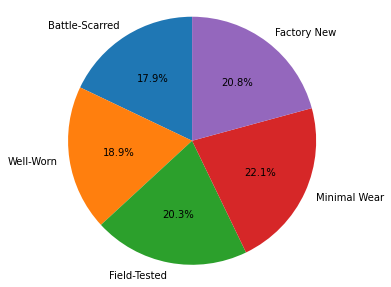

In [768]:
# count of different conditions
conditions = skins["Condition", "Unnamed: 5_level_1"].value_counts()
conditions = conditions.reindex(index = ["Battle-Scarred", "Well-Worn", "Field-Tested", "Minimal Wear", "Factory New"])
fig1, ax1 = plt.subplots()
fig1.set_size_inches(5,5)
ax1.pie(conditions, labels = conditions.index, autopct = "%1.1F%%", startangle = 90)
ax1.axis("equal")
# plt.savefig("graphs/conditions.png", bbox_inches = "tight")

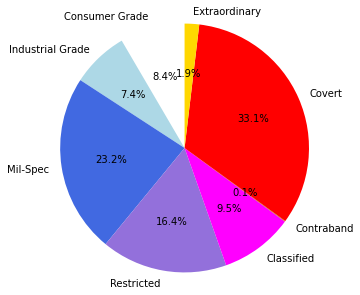

In [6]:
# count of the qualities
qualities = skins["Quality", "Unnamed: 3_level_1"].value_counts()
qualities = qualities.reindex(index = ["Consumer Grade", "Industrial Grade", "Mil-Spec", "Restricted", "Classified", "Contraband", "Covert", "Extraordinary"])
colors = ["white","lightblue", "royalblue", "mediumpurple", "magenta","darkgoldenrod", "red", "gold"]
fig1, ax1 = plt.subplots()
fig1.set_size_inches(5,5)
ax1.pie(qualities, labels = qualities.index, autopct = "%1.1F%%", colors = colors, startangle = 90)
ax1.axis("equal")
# plt.savefig("graphs/qualities.png", bbox_inches = "tight")

In [700]:
skins_data["AVG Price"] = skins_price.mean(axis = 1)

In [701]:
skins_data["AVG Price"].mean()

80.5092499331008

In [702]:
skins_data["AVG Price"].std()

169.59245732642603

In [703]:
skins_data["AVG Daily Volume"] = skins_vol.mean(axis = 1)

In [704]:
skins_data["AVG Daily Volume"].mean()

81.60888995071481

In [705]:
skins_data["AVG Daily Volume"].std()

197.94414434867207

In [710]:
# volume weighted average price
np.nansum((skins_price.mul(skins_vol)).values)/ np.nansum(skins_vol.values)

2.026007909316107

In [212]:
skins_data["Total Vol"] = skins_vol.apply(lambda row: np.nansum(row), axis = 1)

In [263]:
skins_data["First Date Sold"] = skins_price.apply(lambda row: pd.Series.first_valid_index(row), axis = 1)

In [233]:
vol_daily = skins_vol.apply(lambda column: np.nansum(column))
vol_daily.index = vol_daily.index.droplevel(1)
vol_daily = vol_daily.reset_index()
vol_daily["index"] = pd.to_datetime(vol_daily["index"])
vol_daily.columns = ["Date", "Vol"]

vol_daily = vol_daily[(vol_daily["Vol"] != 0)] # removing empty days at the start

vol_daily

,Date,Vol
12,2013-08-13,4.0
13,2013-08-14,87.0
14,2013-08-15,6998.0
15,2013-08-16,17072.0
16,2013-08-17,21164.0
...,...,...
2596,2020-09-09,584624.0
2597,2020-09-10,576704.0
2598,2020-09-11,619819.0
2599,2020-09-12,678882.0


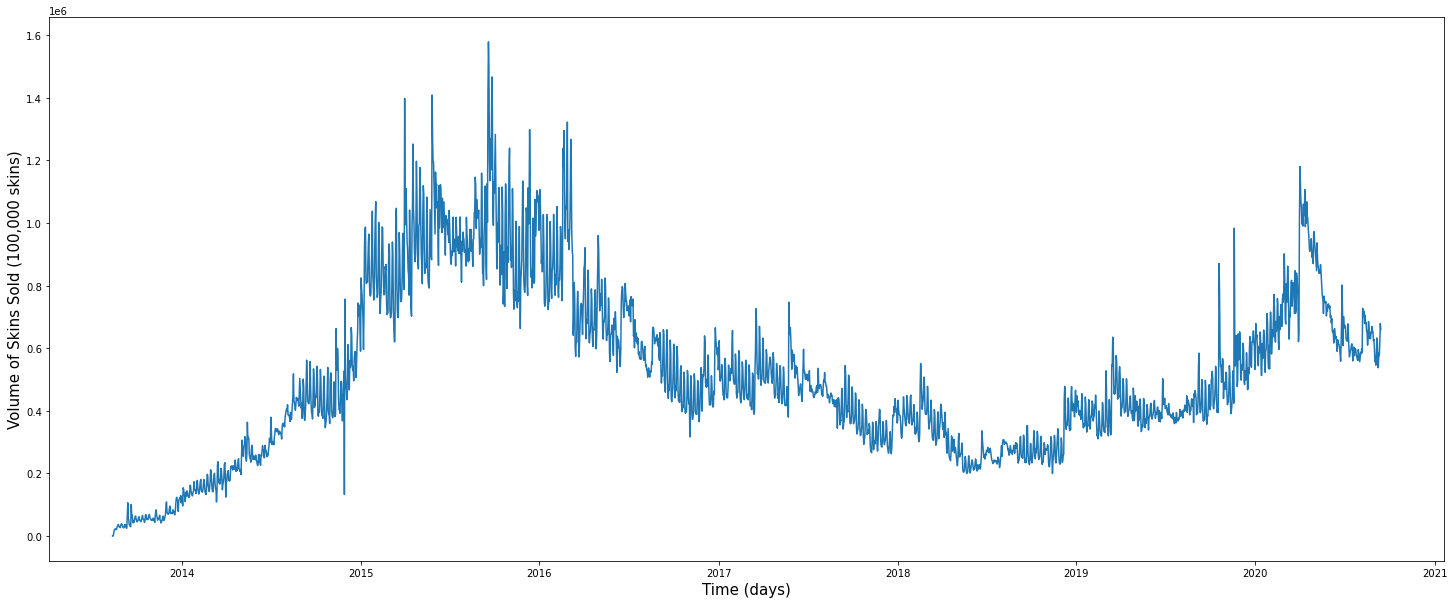

In [235]:
plt.figure(figsize = (25,10))
plt.plot(vol_daily["Date"], vol_daily["Vol"])
plt.xlabel("Time (days)", size = 15)
plt.ylabel("Volume of Skins Sold (100,000 skins)", size = 15)
plt.savefig("graphs/dailyvol_time.png")

# Appreciation Calculations

In [211]:
appreciation_dates = skins_price.apply(lambda x: pd.Series(x.loc[x.first_valid_index():].values), axis = 1)

In [212]:
last_dates = skins_price.fillna(method = "ffill", axis = 1)["2020-09-13"] # forward fill to take the last date sold's price

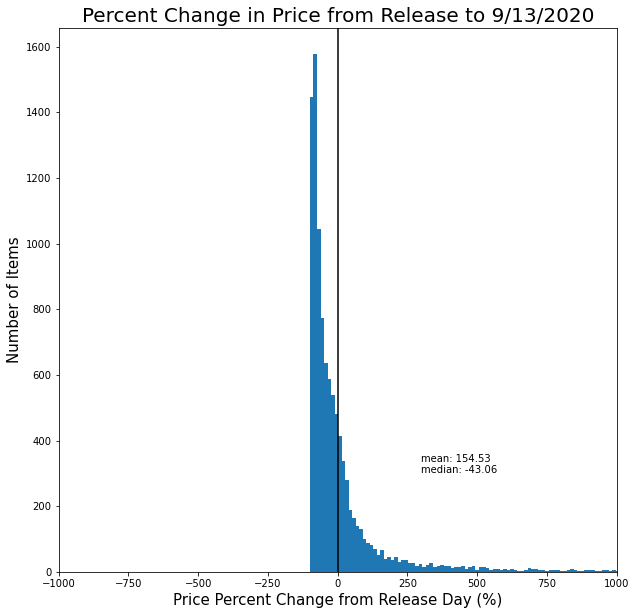

In [76]:
# average appreciation from day 1
app = ((last_dates.sub(appreciation_dates[0])).div(appreciation_dates[0], axis = 0) * 100)
plt.figure(figsize = (10,10))
plt.xlim(-1000, 1000)
plt.xlabel("Price Percent Change from Release Day (%)", size = 15)
plt.ylabel("Number of Items", size =15)
plt.title("Percent Change in Price from Release to 9/13/2020", size = 20)
plt.hist(app, bins = 40000)
plt.annotate(text = "mean: {}\nmedian: {}".format(round(app.mean(), 2), round(app.median(), 2)) ,xy = (300, 300))
plt.axvline(0, color = "black")
plt.savefig("graphs/appreleasenow.png")

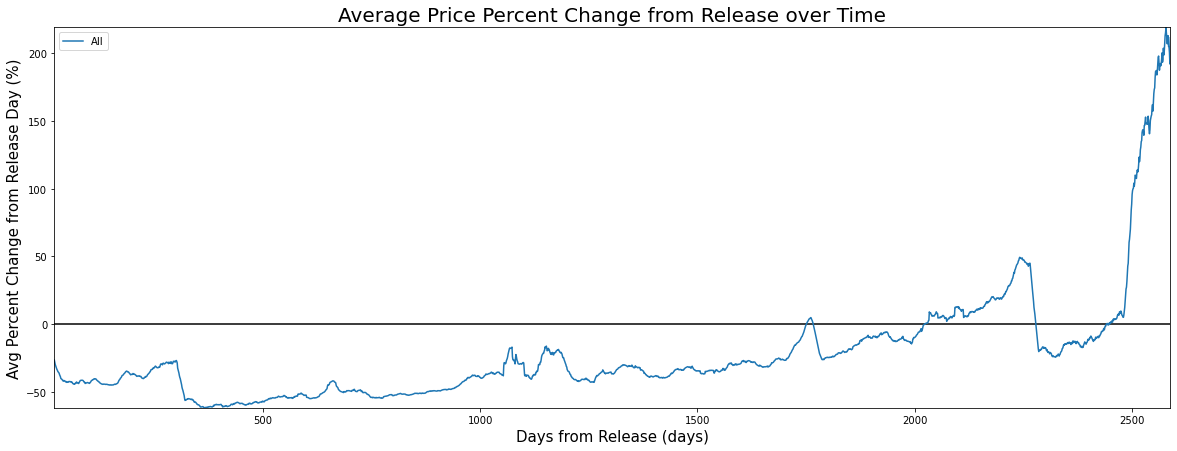

In [247]:
# percent change from day 1
decrease = (((appreciation_dates.sub(appreciation_dates[0], axis = 0).div(appreciation_dates[0], axis = 0)) * 100).mean()).rolling(20).mean()
plt.figure(figsize = (20,7))
plt.margins(0)
plt.axhline(0, color = "black")
plt.xlabel("Days from Release (days)", size = 15)
plt.ylabel("Avg Percent Change from Release Day (%)", size = 15)
plt.title("Average Price Percent Change from Release over Time", size = 20)
#plt.xlim(left = 0, right = 100)
#plt.ylim(bottom = -50, top = 5)
plt.plot(decrease, label = "All")
plt.legend()
# plt.savefig("graphs/percentchangeall3.png")

In [244]:
decrease[0:20].values

array([  0.        ,  -9.88292038, -18.61203848, -19.00175748,
       -21.93730901, -21.07489006, -24.52412853, -25.08850768,
       -32.43200987, -37.11488129, -34.48279864, -23.47631124,
       -28.82994931, -31.47626251, -19.72738242, -35.94119564,
       -39.38883216, -36.14601138, -35.71720836, -35.49678208])

In [215]:
decrease.median()

-33.3829678829742

In [219]:
decrease[:365].std()

8.444360439541654

In [223]:
decrease.where(decrease > 0).dropna()

1751      0.248094
1752      1.034116
1753      1.530237
1754      1.957700
1755      2.491248
           ...    
2585    205.044715
2586    204.705243
2587    200.625777
2588    192.170176
2589    211.566106
Length: 418, dtype: float64

[-0.10970076] 259.90278488270525 0.819883196032069


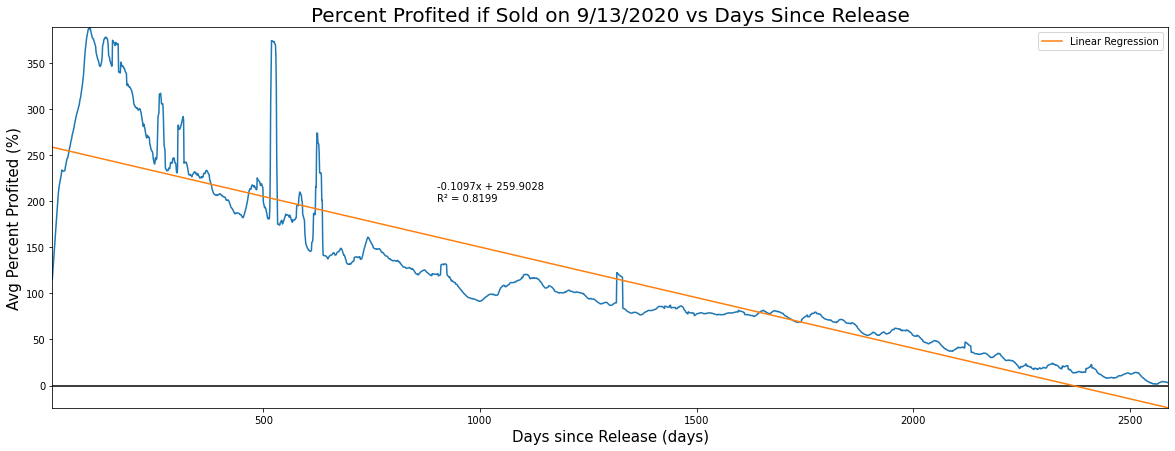

In [292]:
# calculating potential profits if bought and held to this day
profits = (-appreciation_dates.sub(last_dates, axis = 0).div(appreciation_dates) * 100).mean().rolling(14).mean()

y = np.array(profits.dropna())
x = np.array(profits.dropna().index).reshape((-1,1))

# linear regression
model = LinearRegression().fit(x,y)
print(model.coef_, model.intercept_, model.score(x,y))
x_coord = profits.dropna().index
y_coord = model.coef_[0] * x + model.intercept_

plt.figure(figsize = (20,7))
plt.plot(profits)
plt.margins(0)
plt.axhline(0, color = "black")
plt.plot(x_coord, y_coord, label = "Linear Regression")
plt.xlabel("Days since Release (days)", size = 15)
plt.ylabel("Avg Percent Profited (%)", size = 15)
plt.title("Percent Profited if Sold on 9/13/2020 vs Days Since Release", size = 20)
plt.annotate(text = f"{round(model.coef_[0],4)}x + {round(model.intercept_, 4)}\nR² = {round(model.score(x,y), 4)}", xy = (900, 200))
plt.legend()

plt.savefig("graphs/percentgain.png")

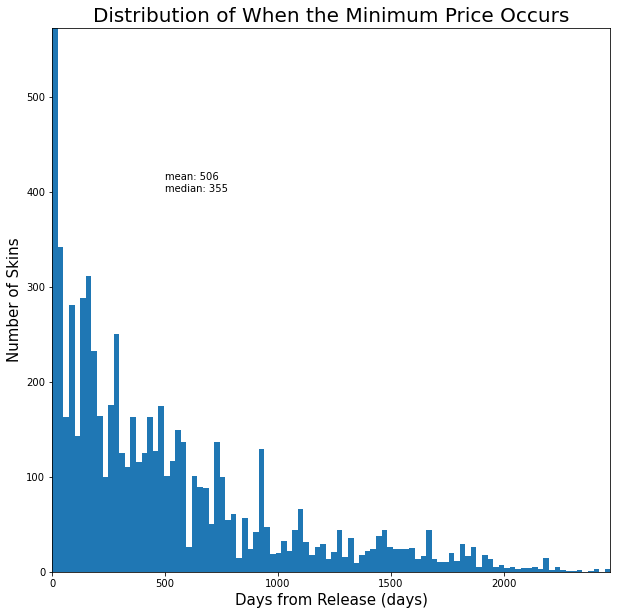

In [189]:
# calculating best possible day to buy in and hold
profits2 = (-appreciation_dates.sub(last_dates, axis = 0).div(appreciation_dates) * 100).idxmax(axis = 1)
plt.figure(figsize = (10, 10))
plt.margins(0)
plt.annotate(text = "mean: {}\nmedian: {}".format(round(profits2.mean()), round(profits2.median())) ,xy = (500, 400))
plt.xlabel("Days from Release (days)", size = 15)
plt.ylabel("Number of Skins", size = 15)
plt.title("Distribution of When the Minimum Price Occurs", size = 20)
plt.hist(profits2, bins = 100)
# plt.savefig("graphs/whentobuyin.png")

In [190]:
profits2.std()

491.46943146018845

(array([1000.,  208.,  196.,  142.,   94.,  144.,  100.,   78.,   92.,
         177.,  197.,   98.,   72.,   78.,   94.,   97.,   68.,  101.,
          87.,   71.,   94.,   72.,  101.,   90.,   90.,   87.,   66.,
          68.,   69.,   72.,   99.,   72.,   54.,   35.,   45.,   39.,
          41.,   50.,   87.,   49.,   43.,   34.,   61.,   39.,   59.,
          64.,   79.,   61.,   38.,   35.,   45.,   55.,   57.,   47.,
          29.,   45.,   34.,   36.,   49.,   53.,   32.,   37.,   38.,
          35.,   51.,   42.,   33.,   33.,   35.,   36.,   40.,   45.,
          26.,   44.,   47.,   27.,   26.,   30.,   35.,   34.,   43.,
          44.,   37.,   23.,   37.,   33.,   27.,   29.,   22.,   16.,
          15.,   15.,   18.,   21.,    8.,    9.,    7.,    8.,    2.,
           7.]),
 array([   0.  ,   25.52,   51.04,   76.56,  102.08,  127.6 ,  153.12,
         178.64,  204.16,  229.68,  255.2 ,  280.72,  306.24,  331.76,
         357.28,  382.8 ,  408.32,  433.84,  459.36,  484.88

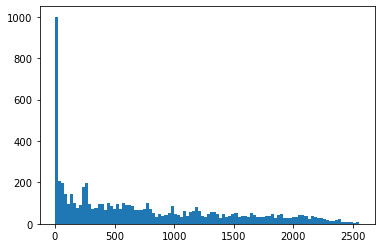

In [293]:
# calculating how much time to wait before selling 
time_sell = (-appreciation_dates.sub(last_dates, axis = 0).div(appreciation_dates) * 100).apply(lambda row: row.iloc[row.idxmax():].idxmin(), axis = 1) - profits2

plt.hist(time_sell, bins = 100)

In [632]:
pd.options.display.max_rows = 10
profits

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
2584    3.623190
2585    3.408934
2586    3.064907
2587    2.584930
2588    2.574514
Length: 2589, dtype: float64

In [325]:
appreciation_dates[0].mean()

93.70981916342413

In [316]:
appreciation_dates[0]

0          0.040
1          0.052
2          0.044
3          0.116
4          0.248
          ...   
10276    158.815
10277    211.999
10278    236.940
10279    288.620
10280    610.750
Name: 0, Length: 10281, dtype: float64

# VOLATILITY MEASUREMENTS

In [646]:
skins_data["20dSTD AVG"] = skins_price.rolling(window = 20, axis = 1).std().mean(axis = 1)
test = ((skins_price.rolling(window = 20, axis = 1).std()).div(skins_price.rolling(window = 20, axis = 1).mean()) * 100).mean(axis = 1)
test

0       111.506095
1       100.319551
2        20.026297
3        30.226849
4        23.363263
           ...    
7270     17.133743
7271           NaN
7272     10.838429
7273     10.069064
7274     11.732715
Length: 6684, dtype: float64

In [668]:
# what are these highly volatile items
len(test.where(test > 10).dropna())

3189

In [172]:
# potential profits
pd.options.display.max_rows = 10
skins_data[((-.15 * skins_data["AVG Price"] + 1.85 * skins_data["20dSTD AVG"]) > 0) & (skins_data["Quality"] != "Extraordinary") & (skins_data["Quality"] != "Covert")]

,Weapon,Collection,Quality,Skin,Condition,StatTrak,Souvenir,20dSTD AVG,AVG Price,Total Vol
0,CZ75-Auto,The Baggage Collection,Consumer Grade,Green Plaid,Battle-Scarred,False,0.0,0.457348,2.349978,26018.0
1,CZ75-Auto,The Baggage Collection,Consumer Grade,Green Plaid,Well-Worn,False,0.0,0.679655,1.722261,16524.0
2,CZ75-Auto,The Baggage Collection,Consumer Grade,Green Plaid,Field-Tested,False,0.0,0.059312,0.283081,174308.0
3,CZ75-Auto,The Baggage Collection,Consumer Grade,Green Plaid,Minimal Wear,False,0.0,0.103822,0.343621,119618.0
4,CZ75-Auto,The Baggage Collection,Consumer Grade,Green Plaid,Factory New,False,0.0,0.279495,0.710472,107019.0
...,...,...,...,...,...,...,...,...,...,...
7261,Negev,Clutch Case,Restricted,Lionfish,Well-Worn,False,0.0,0.201538,0.577728,21643.0
7265,Negev,Clutch Case,Restricted,Lionfish,Battle-Scarred,True,0.0,0.172713,1.286481,4767.0
7270,Negev,The Norse Collection,Classified,Mjölnir,Battle-Scarred,False,0.0,44.352091,226.128971,482.0
7273,Negev,The Norse Collection,Classified,Mjölnir,Minimal Wear,False,0.0,32.343216,381.300213,1468.0


In [157]:
skins_data[((2 * skins_data["20dSTD AVG"] / skins_data["AVG Price"]) > .15)]

,Weapon,Collection,Quality,Skin,Condition,StatTrak,Souvenir,20dSTD AVG,AVG Price,Total Vol
0,CZ75-Auto,The Baggage Collection,Consumer Grade,Green Plaid,Battle-Scarred,False,0.0,0.457348,2.349978,26018.0
1,CZ75-Auto,The Baggage Collection,Consumer Grade,Green Plaid,Well-Worn,False,0.0,0.679655,1.722261,16524.0
2,CZ75-Auto,The Baggage Collection,Consumer Grade,Green Plaid,Field-Tested,False,0.0,0.059312,0.283081,174308.0
3,CZ75-Auto,The Baggage Collection,Consumer Grade,Green Plaid,Minimal Wear,False,0.0,0.103822,0.343621,119618.0
4,CZ75-Auto,The Baggage Collection,Consumer Grade,Green Plaid,Factory New,False,0.0,0.279495,0.710472,107019.0
...,...,...,...,...,...,...,...,...,...,...
7256,Negev,Revolver Case,Restricted,Power Loader,Well-Worn,True,0.0,0.200527,2.650673,11258.0
7260,Negev,Clutch Case,Restricted,Lionfish,Battle-Scarred,False,0.0,0.275676,0.546784,26209.0
7261,Negev,Clutch Case,Restricted,Lionfish,Well-Worn,False,0.0,0.201538,0.577728,21643.0
7265,Negev,Clutch Case,Restricted,Lionfish,Battle-Scarred,True,0.0,0.172713,1.286481,4767.0


In [123]:
len(skins_data)

10281

In [124]:
len(skins_data[skins_data["20dSTD AVG"] < 1])

5794

In [121]:
len(skins_data[skins_data["20dSTD AVG"] < 2])

6222

In [128]:
skins_data[skins_data["20dSTD AVG"] < 2]["AVG Price"].mean()

3.4960115049852347

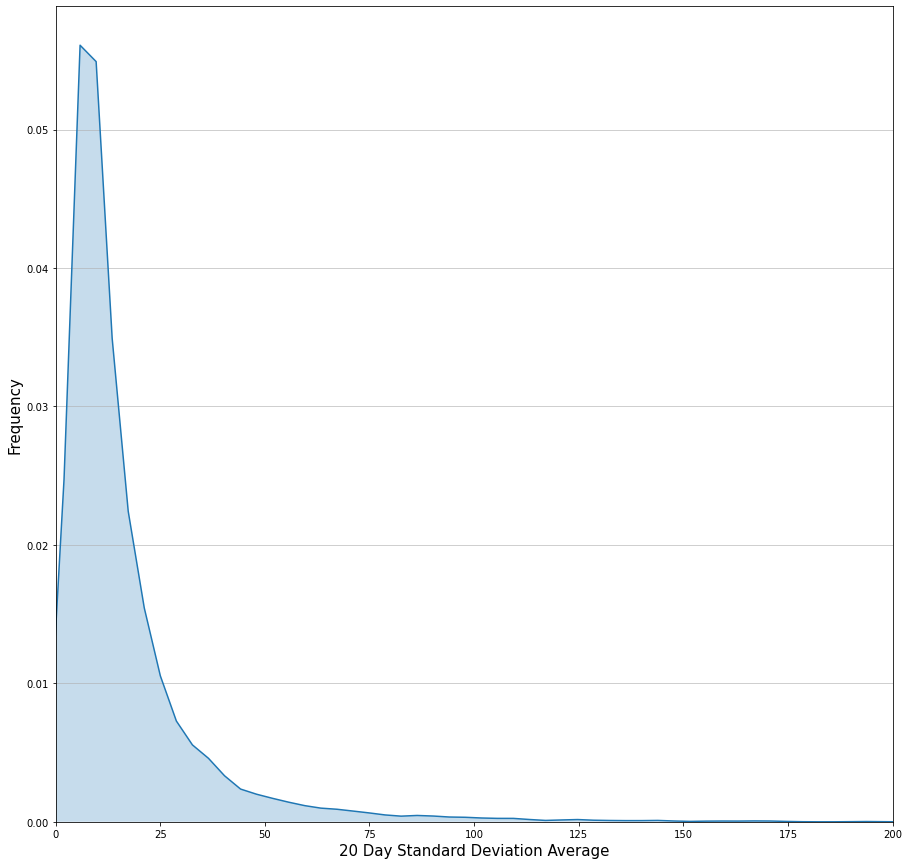

In [648]:
plt.figure(figsize = (15,15))
sns.kdeplot(test, shade = True)
plt.grid(axis = "y", alpha = .75)
plt.xlabel("20 Day Standard Deviation Average", size = 15)
plt.ylabel("Frequency", size = 15)
plt.xlim(0, 200)
maxfreq = n.max()

## 20d STD AVG vs AVG Price
### UNUSED

<Figure size 1080x1080 with 0 Axes>

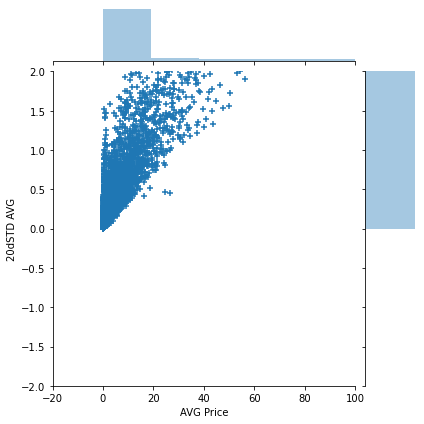

In [118]:
plt.figure(figsize = (15,15))
sns.jointplot(x = skins_data["AVG Price"], y = skins_data["20dSTD AVG"], dropna = True, xlim = (-20, 100), ylim = (-2, 2), marker = "+")

<Figure size 1080x1080 with 0 Axes>

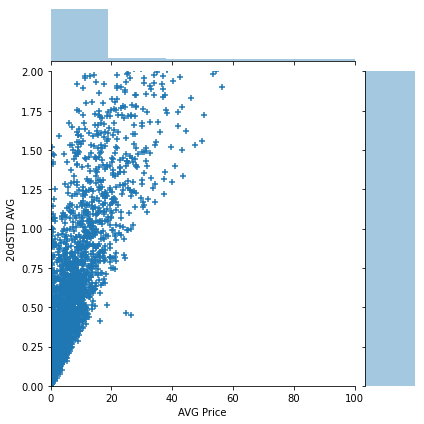

In [134]:
plt.figure(figsize = (15,15))
sns.jointplot(x = skins_data["AVG Price"], y = skins_data["20dSTD AVG"], dropna = True, xlim = (0, 100), ylim = (0, 2), marker = "+")

In [264]:
skins_data

,Weapon,Collection,Quality,Skin,Condition,StatTrak,Souvenir,20dSTD AVG,AVG Price,Total Vol,First Date Sold
0,CZ75-Auto,The Baggage Collection,Consumer Grade,Green Plaid,Battle-Scarred,False,0.0,0.457348,2.349978,26018.0,2014-07-02
1,CZ75-Auto,The Baggage Collection,Consumer Grade,Green Plaid,Well-Worn,False,0.0,0.679655,1.723136,16523.0,2014-07-02
2,CZ75-Auto,The Baggage Collection,Consumer Grade,Green Plaid,Field-Tested,False,0.0,0.059312,0.282976,174306.0,2014-07-02
3,CZ75-Auto,The Baggage Collection,Consumer Grade,Green Plaid,Minimal Wear,False,0.0,0.103822,0.343398,119617.0,2014-07-02
4,CZ75-Auto,The Baggage Collection,Consumer Grade,Green Plaid,Factory New,False,0.0,0.279495,0.710319,107018.0,2014-07-02
...,...,...,...,...,...,...,...,...,...,...,...
10276,Hydra Gloves,Clutch Case,Extraordinary,Mangrove,Battle-Scarred,False,0.0,5.974867,119.711260,1249.0,2018-02-18
10277,Hydra Gloves,Clutch Case,Extraordinary,Mangrove,Well-Worn,False,0.0,NaN,122.052609,756.0,2018-02-18
10278,Hydra Gloves,Clutch Case,Extraordinary,Mangrove,Field-Tested,False,0.0,5.890154,126.858526,4274.0,2018-02-17
10279,Hydra Gloves,Clutch Case,Extraordinary,Mangrove,Minimal Wear,False,0.0,7.645027,165.185686,961.0,2018-02-17
